# Pokemon Legendary Classification<br>
## Table of Content

1. [Problem Statement](#section1)<br>
2. [Data Loading and Description](#section2)<br>
3. [Check for Missing Data](#section3)<br>
4. [Exploratory Data Analysis](#section4)<br>
5. [Running the Prediction Algorithms](#section5)<br>
6. [Results](#section6)<br>

## 1. Problem Statement <a class="anchor" id="section1"></a>

<br>
The Poekomon dataset is a listing of all Pokemon species containing data about their type and statistics.
Our objective here is identify if a Pokemon species is legendary or not given the various descriptions about them.<br>
<br>
The target variable <b>is_legendary</b>: <br>
0 --> denotes is not legendary<br>
1 --> denotes is legendary<br>

#### Import the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import math
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

#### User Defined Functions

In [2]:
def plot_bars(plot_df, title):
    df = pd.DataFrame(plot_df)
    df.plot(kind='bar', figsize=(12,8))
    plt.xticks(rotation=45)
    for i in range(0, len(df)):
        plt.text(x=i, y=df.iloc[i][0], s=df.iloc[i][0])
    plt.title(title);
    
def draw_heatmap(plot_df):
    df = plot_df.copy()
    data_corr = round(df.corr(),ndigits=2)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(data_corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(10,240,n=256),square=True, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    
def draw_scatterplot(plot_df, x, y, hue, color_dict, outlier):
    df = plot_df.copy()
    df['is_legendary'] = df['is_legendary'].map({0:'Not Legendary', 1:'Legendary'})
    x = x
    y = y
    colors = color_dict
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=x, y=y, data=df, hue=hue, s=70)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(bbox_to_anchor=(1.05, 1))
    outliers = df[(df[x]>outlier) | (df[y]>outlier)][['name',x,y]].reset_index(drop=True)
    for i in range(0, len(outliers)):
        plt.text(x=outliers.iloc[i][x], y=outliers.iloc[i][y], s=df.iloc[i]['name'])
    plt.title('Scatter Plot of ' + str(x) + ' vs ' + str(y))

def draw_barplot(plot_df, columns, group):
    df = plot_df.copy()
    df['is_legendary'] = df['is_legendary'].map({1:'Legendary', 0:'Not Legendary'})
    df.groupby(group)[columns].mean().T.plot(kind='bar', figsize=(20,8), color=('indianred','b'))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=15)
    #for i in range(0, len(df)):
    #    plt.text(x=i, y=df.iloc[i][0], s=df.iloc[i][0])
    plt.title('Mean scores of attributes by Legendary type')        

def draw_boxplot(plot_df):
    df = plot_df.copy()
    plt.figure(figsize=(12,8))
    sns.boxplot(data = df)
    plt.title('Box Plot')
    

def draw_piechart(plot_df):
    df = plot_df.copy()
    items = df.value_counts().index.to_list()
    space = np.ones(len(items))/10
    df.value_counts().plot(kind='pie', explode=space, fontsize=14, autopct='%3.1f%%', wedgeprops=dict(width=0.15), 
                                       shadow=True, startangle=160, figsize=(10,10), cmap='inferno', legend=True);

def mean_attribute_plot(tipe, attribute, plot_df):
    df = pd.DataFrame(plot_df.groupby(tipe)[attribute].mean()).reset_index()
    fig, axes = plt.subplots(3,1, figsize=(12,8))
    sns.stripplot(data=plot_df, x=tipe, y=attribute,ax=axes[0], jitter=True)
    sns.boxplot(data=plot_df, x=tipe, y=attribute, ax=axes[1], orient='v')
    sns.barplot(df[tipe],df[attribute], ax=axes[2])
    

def impute_missing(missing_df, tipe):
    df = missing_df.copy()
    missing_index = df[df.isnull()].index
    
    if (tipe=='num'):
        missing_arr = np.array(df).reshape(-1,1)
        imputer = KNNImputer()
        fill_arr = imputer.fit_transform(missing_arr)
        df.loc[missing_index] = np.squeeze(fill_arr[missing_index])
    else:
        encoder = OrdinalEncoder()
        notnull = np.array(df[~df.isnull()]).reshape(-1,1)
        encoded_arr = encoder.fit_transform(notnull)
        df.loc[df.notnull()] = np.squeeze(encoded_arr)
        imputer = IterativeImputer()
        missing_arr = np.array(df).reshape(-1,1)
        fill_arr = imputer.fit_transform(missing_arr)
        df.loc[:] = np.squeeze(encoder.inverse_transform(fill_arr))
    return df

def encoder(missing_df):
    df = missing_df.copy()
    notnulls = np.array(df[df.notnull()]).reshape(-1,1)
    encoder = OrdinalEncoder()
    df.loc[df.notnull()] = np.squeeze(encoder.fit_transform(notnulls))
    return encoder, df

def scale_the_train_dataset(dataset):
    dataset1 = dataset.iloc[:,0:10].values
    dataset2 = dataset.iloc[:,10:].values
    sc = StandardScaler()
    dataset1_scaled = sc.fit_transform(dataset1)
    dataset_scaled = np.concatenate((dataset1_scaled, dataset2), axis=1)
    return sc, dataset_scaled

# Scale the Train dataset
def scale_the_test_dataset(dataset, sc_obj):
    dataset1 = dataset.iloc[:,0:10].values
    dataset2 = dataset.iloc[:,10:].values
    sc = sc_obj
    dataset1_scaled = sc.transform(dataset1)
    dataset_scaled = np.concatenate((dataset1_scaled, dataset2), axis=1)
    return dataset_scaled

# Perform PCA on train dataset
def perform_pca_train(dataset, n):
    pca = PCA(n).fit(dataset)
    n_comp = pca.n_components_
    print(pca.explained_variance_ratio_)
    print(np.cumsum(pca.explained_variance_ratio_))
    plt.plot(np.round(np.cumsum(pca.explained_variance_ratio_),decimals=3)*100)
    print('No. of components: ', n_comp)
    pca = PCA(n_components=n_comp).fit(dataset)
    dataset_pca = pca.transform(dataset)
    return pca, dataset_pca

# Perform PCA on test dataset
def perform_pca_test(dataset, pca_obj):
    pca = pca_obj
    dataset_pca = pca.transform(dataset)
    return dataset_pca

def train_predict(train_data, train_classfiers, test_data, algorithm):
    model = algorithm
    model.fit(train_data, train_classfiers)
    train_prediction = model.predict(train_data)
    test_prediction = model.predict(test_data)
    return train_prediction, test_prediction

def model_evaluation(actuals, predictions, algorithm):
    # Confusion matrix
    conf_matrix = pd.DataFrame(confusion_matrix(actuals, predictions))
    print("\n ",algorithm )
    print("CONFUSION MATRIX")
    print(conf_matrix)
    
    # Mean absolute error
    mae = round(metrics.mean_absolute_error(actuals, predictions),2)
    print('Mean Absolute Error: {}'.format(mae))
    
    # Mean Squared Error
    mse = round(metrics.mean_squared_error(actuals, predictions),2)
    print('Mean Squaared Error: {}'.format(mse))
    
    # Root Mean Square Error
    rmse = round(np.sqrt(mse),2)
    print('Root Mean Squaared Error: {}'.format(rmse))
    
    # Accuracy
    accuracy = round(accuracy_score(actuals, predictions),2)
    print('Accuracy: {}'.format(accuracy))
    
    # Precision score
    precision = round(metrics.precision_score(actuals, predictions, average='macro'),2)
    print('Precision : {}'.format(precision))
    
    # Recall score
    recall = round(metrics.recall_score(actuals, predictions, average='macro'),2)
    print('Recall : {}'.format(recall))
    
    f1 = round(metrics.fbeta_score(actuals, predictions, average='macro', beta=2),2)
    print('F1_score : {}'.format(f1))
    
    
    alg = algorithm
    df = pd.DataFrame(data=[{'Algorithm': alg, 'MAE':mae, 'MSE':mse, 'RMSE':rmse,
                            'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1_Score':f1}])
        
    return df[['Algorithm', 'MAE', 'MSE', 'RMSE', 'Accuracy', 'Precision', 'Recall', 'F1_Score']]

## 2. Data loading and Description <a class="anchor" id="section2"></a>
The dataset (802 rows) contains features of the each Pokemon species. <br><br>
__Data Fields__
1. name - The English Name of the Pokemon
2. japanese_name - The original japanese name of the pokemon
3. pokedex_number - The entry number of the Pokemon in the National Pokedex
4. percentage_male - The percentage of the species that are male. Blank if the Pokemon is genderless
5. type1 - The Primary type of the Pokemon
6. type2 - The secondary type of the pokemon
7. classification - The Classification of the Pokemon as described by the Sun and Moon Pokedox
8. height_m - Height of the Pokemon in metres
9. weight_kg - Weight of the Pokemon in kilograms
10. capture_rate - Capture Rate of the Pokemon
11. base_egg_steps - The number of steps required to hatch an egg of the Pokemon
12. abilities - A stringified list of abilities that the Pokemon is capable of having
13. experience_growth - THe Experience Growth of the Pokemon
15. against_? - Eighteen features that denote the amount of damage taken against an attack of a particular type
16. hp - The Base Hitpoints of the Pokemon
17. attack - The Base attack of the Pokemon
18. defense - The Base defense of the Pokemon
19. sp_attack - The Base special attack of the Pokemon
20. sp_defense - The Base special defense of the Pokemon
21. speed - The Base speed of the Pokemon
22. generation - The numbered generation which the Pokemon was first introduced
23. is_legendary - Denotes if the Pokemon is legendary

#### Importing the dataset

In [3]:
pokemon = pd.read_csv('pokemon.csv')
pokemon.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


##### Describing the dataset 

In [4]:
pokemon.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,781.000000,801.000000,703.000000,801.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,1.163892,68.958801,55.155761,401.000000,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,1.080326,26.576015,20.261623,231.373075,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,...,0.100000,1.000000,0.000000,1.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,...,0.600000,50.000000,50.000000,201.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,65.000000,50.000000,401.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.500000,80.000000,50.000000,601.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,14.500000,255.000000,100.000000,801.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000


## 3. Check for missing data <a class="anchor" id="section3"></a>

In [5]:
pokemon.isnull().sum()

abilities              0
against_bug            0
against_dark           0
against_dragon         0
against_electric       0
against_fairy          0
against_fight          0
against_fire           0
against_flying         0
against_ghost          0
against_grass          0
against_ground         0
against_ice            0
against_normal         0
against_poison         0
against_psychic        0
against_rock           0
against_steel          0
against_water          0
attack                 0
base_egg_steps         0
base_happiness         0
base_total             0
capture_rate           0
classfication          0
defense                0
experience_growth      0
height_m              20
hp                     0
japanese_name          0
name                   0
percentage_male       98
pokedex_number         0
sp_attack              0
sp_defense             0
speed                  0
type1                  0
type2                384
weight_kg             20
generation             0


#### Look at the dtypes

In [6]:
pokemon.dtypes

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

The column capture rate is mostly numeric values except for the value at row index 773

In [7]:
pokemon.at[773,'capture_rate'] = '30'

#### Convert the capture rate to numeric format

In [8]:
pokemon['capture_rate'] = pokemon['capture_rate'].astype('int64')

In [9]:
pokemon['capture_rate']

0       45
1       45
2       45
3       45
4       45
      ... 
796     25
797    255
798     15
799      3
800      3
Name: capture_rate, Length: 801, dtype: int64

#### Look for categorical columns and encode them before using KNN imputer for missing values

In [10]:
for dtype, i in zip(pokemon.dtypes, range(0, len(pokemon.dtypes))):
    if (dtype=='object'):
        print(pokemon.dtypes.index[i])

abilities
classfication
japanese_name
name
type1
type2


#### Creating a new dataframe by dropping the names columns as they are not relevant in imputing

In [11]:
missing_df = pokemon.drop(columns=['name','japanese_name'])
missing_df

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


In [12]:
encoder_abl, missing_df['abilities'] = encoder(missing_df['abilities'])
encoder_clf, missing_df['classfication'] = encoder(missing_df['classfication'])
encoder_type1, missing_df['type1'] = encoder(missing_df['type1'])
encoder_type2, missing_df['type2'] = encoder(missing_df['type2'])

In [13]:
cols = missing_df.columns

In [14]:
mice_impute = IterativeImputer()
missing_df = pd.DataFrame(mice_impute.fit_transform(missing_df), columns = cols)
missing_df

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,243.0,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.100000,1.0,65.0,65.0,45.0,9.0,13.000000,6.9,1.0,0.0
1,243.0,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.100000,2.0,80.0,80.0,60.0,9.0,13.000000,13.0,1.0,0.0
2,243.0,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.100000,3.0,122.0,120.0,80.0,9.0,13.000000,100.0,1.0,0.0
3,21.0,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.100000,4.0,60.0,50.0,65.0,6.0,7.580114,8.5,1.0,0.0
4,21.0,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.100000,5.0,80.0,65.0,80.0,6.0,7.459444,19.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,11.0,0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,69.702718,797.0,107.0,101.0,61.0,16.0,7.000000,999.9,7.0,1.0
797,11.0,1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,54.309946,798.0,59.0,31.0,109.0,9.0,16.000000,0.1,7.0,1.0
798,11.0,2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,55.721112,799.0,97.0,53.0,43.0,1.0,2.000000,888.0,7.0,1.0
799,288.0,2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,73.213061,800.0,127.0,89.0,79.0,14.0,10.241338,230.0,7.0,1.0


#### Decode the encoded the categorical values

In [15]:
missing_df['abilities'] = encoder_abl.inverse_transform(np.array(missing_df['abilities']).reshape(-1,1))
missing_df['classfication'] = encoder_clf.inverse_transform(np.array(missing_df['classfication']).reshape(-1,1))
missing_df['type1'] = encoder_type1.inverse_transform(np.array(missing_df['type1']).reshape(-1,1))
missing_df['type2'] = encoder_type2.inverse_transform(np.array(missing_df['type2']).reshape(-1,1))

#### Assign the missing columns values in the main pokemon dataset

In [16]:
for nulc, i in zip(pokemon.isnull().sum(), range(0, len(pokemon.isnull().sum()))):
    if (nulc!=0):
        print(pokemon.isnull().sum().index[i])

height_m
percentage_male
type2
weight_kg


In [17]:
pokemon['height_m'] = missing_df['height_m']
pokemon['percentage_male'] = missing_df['percentage_male']
pokemon['type2'] = missing_df['type2']
pokemon['weight_kg'] = missing_df['weight_kg']

#### Check if all missing values have addressed

In [18]:
pokemon.isnull().sum().sum()

0

## 4. Exploratory Data Analysis <a class="anchor" id="section4"></a>

In [19]:
pokemon.dtypes

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate           int64
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

#### How are Pokemon numbers distributed across generations

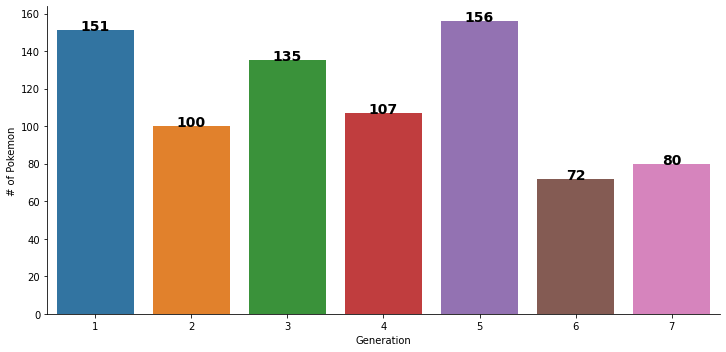

In [20]:
plot = sns.catplot(x='generation', data=pokemon, kind='count', height=5, aspect=2).set_axis_labels('Generation', '# of Pokemon')
# To plot the data labels
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+2, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=14)

No noticeable trend in the generations

### Checking the Primary types of Pokemon

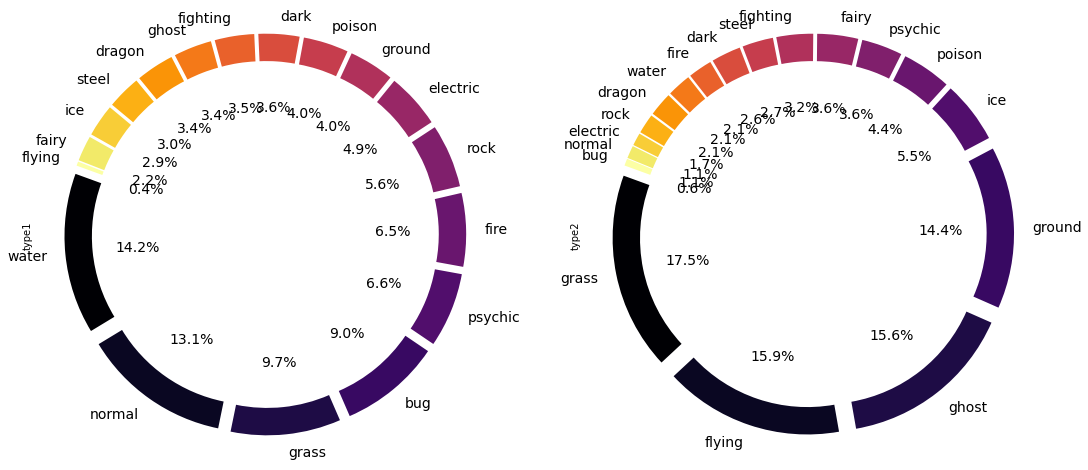

In [21]:
fig, axes = plt.subplots(1,2, figsize=(18,14))
items = pokemon['type1'].value_counts().index.to_list()
space = np.ones(len(items))/10
pokemon['type1'].value_counts().plot(kind='pie', explode=space, fontsize=14, autopct='%3.1f%%', wedgeprops=dict(width=0.15), 
                                       shadow=False, startangle=160, ax=axes[0], cmap='inferno', legend=False);

pokemon['type2'].value_counts().plot(kind='pie', explode=space, fontsize=14, autopct='%3.1f%%', wedgeprops=dict(width=0.15), 
                                       shadow=False, startangle=160, ax=axes[1], cmap='inferno', legend=False);

Lets dig a bit more deeper and see primary types of pokemon across generations

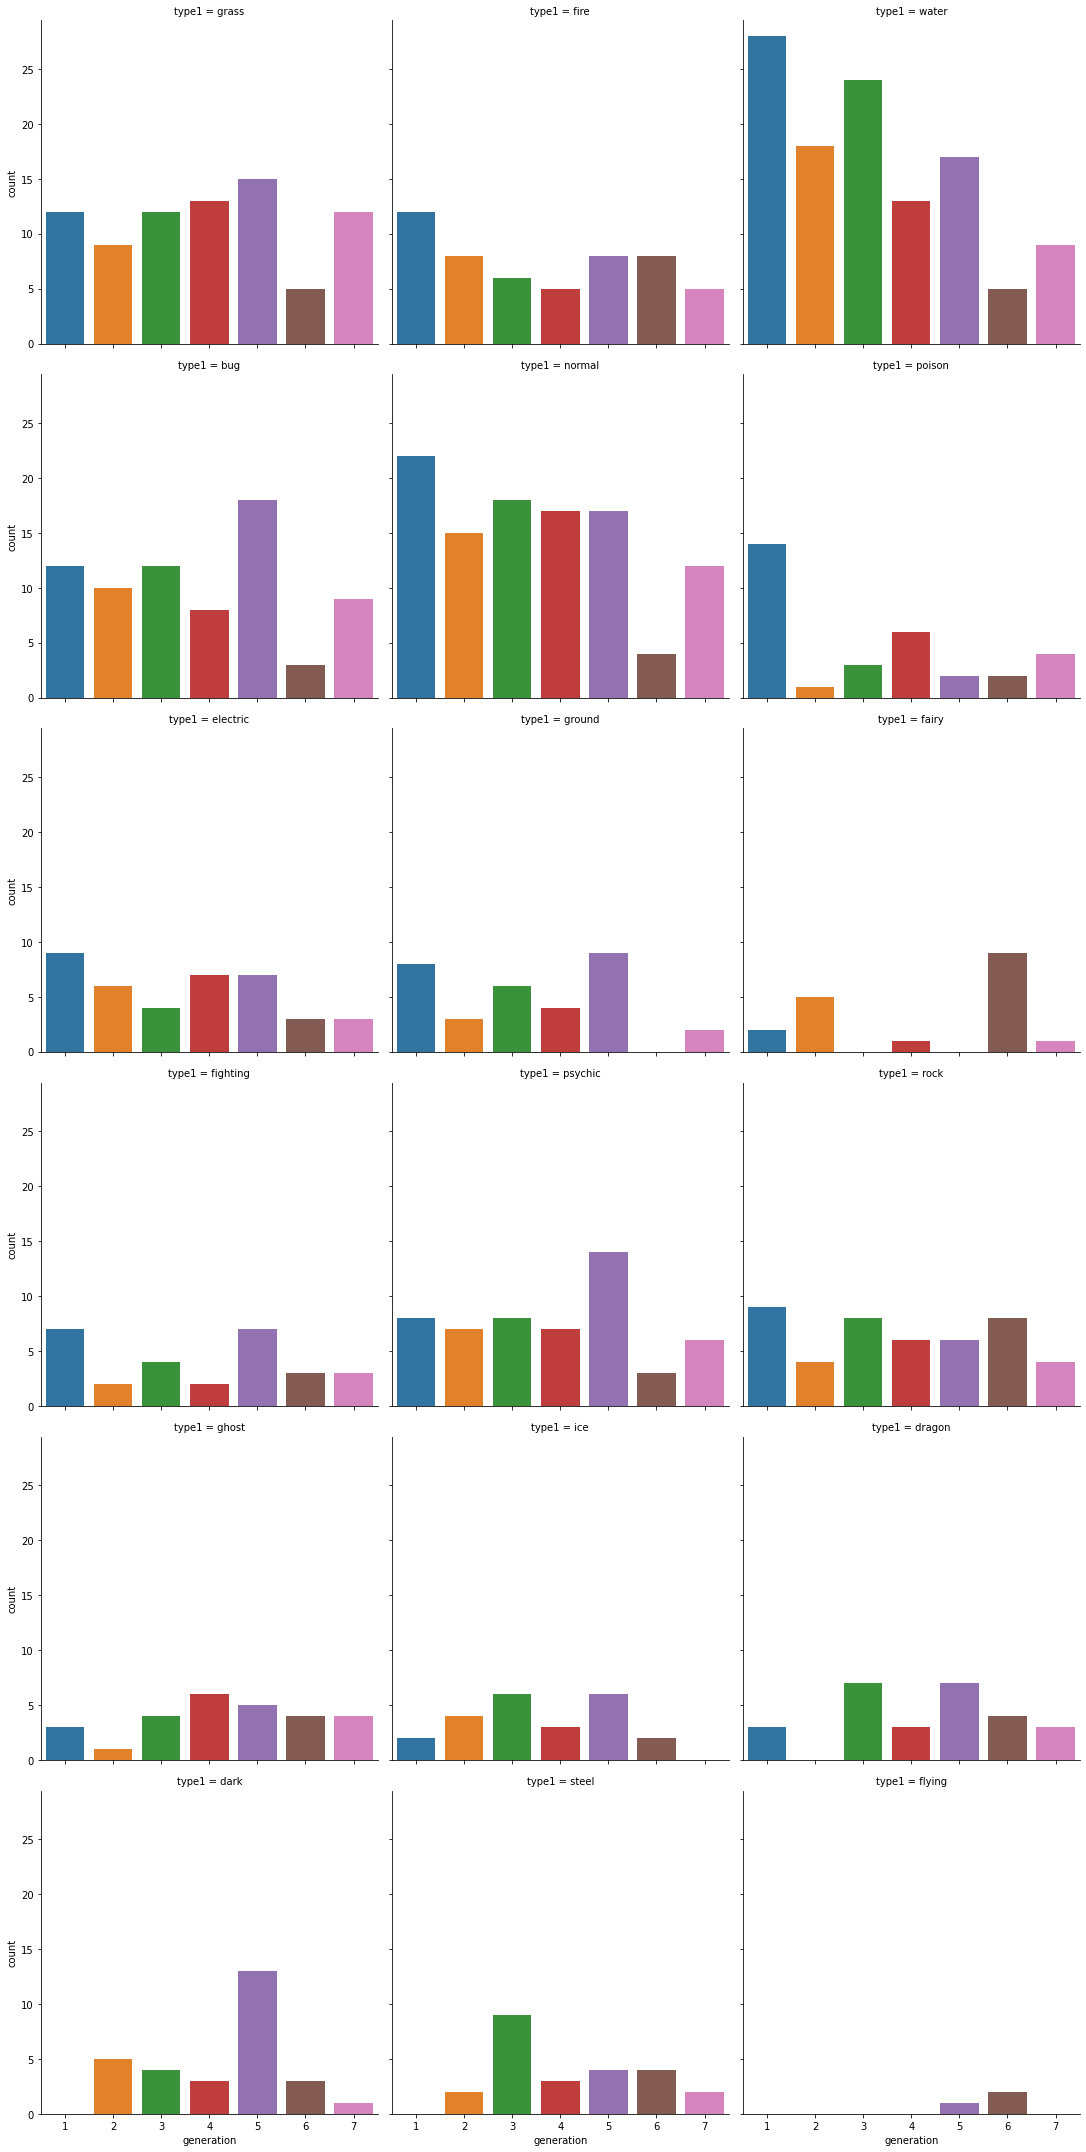

In [22]:
sns.catplot(x='generation', data=pokemon, col='type1', kind='count', col_wrap=3)

Few insights:<br>
Poision type Pokemon is popular in 1st generation <br>
Generation 5 has more psychic and dark type Pokemon <br>
Flying type Pokemon which has a major share(15.2%) in the type2 was introduced late in 5th generation <br>

#### Let us rank the Pokemon species and look at the strongest and weakest Pokemon speceies

##### Let us define a strength statistics which is sum of Z-scores of the attributes

In [23]:
stat_cols = ['hp','attack','defense','sp_attack', 'sp_defense', 'speed']
#poke_stats = pokemon[stat_cols]
#poke_stats['total'] = np.sum(poke_stats,axis=1)
pokestats = pokemon[stat_cols].apply(lambda x: (x-x.mean())/x.std())
pokestats['strength'] = pokestats.sum(axis='columns')
pokestats['name'] = pokemon['name']
pokestats['type1'] = pokemon['type1']
pokestats['type2'] = pokemon['type2']
pokestats['generation'] = pokemon['generation']
pokestats['is_legendary'] = pokemon['is_legendary']
pokestats = pokestats[['name', 'type1','type2','generation','is_legendary',
                      'hp','attack','defense','sp_attack', 'sp_defense', 'speed','strength']]
pokestats

,name,type1,type2,generation,is_legendary,hp,attack,defense,sp_attack,sp_defense,speed,strength
0,Bulbasaur,grass,poison,1,0,-0.901520,-0.897349,-0.780286,-0.194903,-0.211554,-0.738025,-3.723637
1,Ivysaur,grass,poison,1,0,-0.337101,-0.493105,-0.325285,0.268720,0.325262,-0.219132,-0.780640
2,Venusaur,grass,poison,1,0,0.415457,0.688530,1.624720,1.566867,1.756773,0.472727,6.525074
3,Charmander,fire,flying,1,0,-1.127287,-0.804062,-0.975286,-0.349445,-0.748371,-0.046167,-4.050618
4,Charmeleon,fire,flying,1,0,-0.412357,-0.430914,-0.487785,0.268720,-0.211554,0.472727,-0.801163
...,...,...,...,...,...,...,...,...,...,...,...,...
796,Celesteela,steel,flying,7,1,1.055132,0.719626,0.974718,1.103243,1.076806,-0.184539,4.744986
797,Kartana,grass,steel,7,1,-0.374729,3.207279,1.884720,-0.380353,-1.428339,1.475921,4.384500
798,Guzzlord,dark,dragon,7,1,5.796249,0.719626,-0.650286,0.794161,-0.641008,-0.807211,5.211531
799,Necrozma,psychic,ground,7,1,1.055132,0.906200,0.909718,1.721408,0.647352,0.438134,5.677944


#### Top 15 strongest Pokemon

In [24]:
pokestats.sort_values(by='strength', ascending=False).head(15)

,name,type1,type2,generation,is_legendary,hp,attack,defense,sp_attack,sp_defense,speed,strength
149,Mewtwo,psychic,grass,1,1,1.393783,2.243314,-0.097784,3.792260,1.756773,2.548301,11.636647
383,Rayquaza,dragon,flying,3,1,1.356155,3.176184,0.877218,3.359545,1.041018,1.683478,11.493598
381,Kyogre,water,grass,3,1,1.168016,2.243314,0.552217,3.359545,3.188284,0.818656,11.330031
382,Groudon,ground,ground,3,1,1.168016,3.176184,2.827223,2.432298,0.683140,0.818656,11.105515
717,Zygarde,dragon,ground,6,1,5.532854,0.688530,1.559720,0.608711,0.862079,0.645691,9.897584
492,Arceus,normal,grass,4,1,1.920574,1.310444,1.527220,1.505050,1.756773,1.856443,9.876503
379,Latias,dragon,psychic,3,1,0.415457,0.688530,1.527220,2.123215,2.830407,1.510514,9.095342
645,Kyurem,dragon,ice,5,1,2.108713,1.310444,0.552217,3.050462,1.041018,0.991620,9.054475
247,Tyranitar,rock,dark,2,0,1.168016,2.678653,2.502222,0.732344,1.756773,0.161390,8.999398
372,Salamence,dragon,flying,3,0,0.979876,2.087835,1.852220,1.505050,0.683140,1.856443,8.964564


So our definition of strong Pokemon may not reflect that the Pokemon is legendary as there are non-legendary Pokemons who are stronger than the Legendary Pokemons

#### Top 15 weakest Pokemons

In [25]:
pokestats.sort_values(by='strength').head(15)

,name,type1,type2,generation,is_legendary,hp,attack,defense,sp_attack,sp_defense,speed,strength
190,Sunkern,grass,ghost,2,0,-1.465938,-1.488166,-1.397787,-1.276692,-1.464127,-1.256919,-8.349629
297,Azurill,normal,fairy,3,0,-0.713380,-1.799123,-1.072787,-1.585774,-1.106249,-1.602848,-7.880161
400,Kricketot,bug,ground,4,0,-1.202543,-1.643645,-1.040286,-1.431233,-1.070461,-1.429883,-7.818052
264,Wurmple,bug,ground,3,0,-0.901520,-1.021731,-1.235287,-1.585774,-1.464127,-1.602848,-7.811287
12,Weedle,bug,poison,1,0,-1.089659,-1.332688,-1.397787,-1.585774,-1.822004,-0.565061,-7.792974
9,Caterpie,bug,ground,1,0,-0.901520,-1.488166,-1.235287,-1.585774,-1.822004,-0.738025,-7.770777
279,Ralts,psychic,fairy,3,0,-1.541194,-1.643645,-1.560288,-0.813068,-1.285188,-0.910990,-7.754372
663,Scatterbug,bug,ground,6,0,-1.164915,-1.332688,-1.072787,-1.369417,-1.643066,-1.083954,-7.666826
128,Magikarp,water,ghost,1,0,-1.842218,-2.110080,-0.585285,-1.740316,-1.822004,0.472727,-7.627176
788,Cosmog,psychic,ground,7,1,-0.976776,-1.519262,-1.365287,-1.307600,-1.428339,-1.014768,-7.612032


In [26]:
pokestats.sort_values(by='strength', ascending=False)[['type1','type2','strength','is_legendary']].head(10)

,type1,type2,strength,is_legendary
149,psychic,grass,11.636647,1
383,dragon,flying,11.493598,1
381,water,grass,11.330031,1
382,ground,ground,11.105515,1
717,dragon,ground,9.897584,1
492,normal,grass,9.876503,1
379,dragon,psychic,9.095342,1
645,dragon,ice,9.054475,1
247,rock,dark,8.999398,0
372,dragon,flying,8.964564,0


Dragon type is the most occuring type1 in the strongest Pokemon. <br>
In type2 Pokemon grass, ground and flying are the most occuring

### Let us define the vulnerability of the Pokemon

In [27]:
vul_cols = ['against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight',
            'against_fire', 'against_flying', 'against_ghost', 'against_grass', 'against_ground',
            'against_ice', 'against_normal', 'against_poison', 'against_psychic',
            'against_rock', 'against_steel', 'against_water']

pokevuls = pokemon[vul_cols].apply(lambda x: (x-x.mean())/x.std())
pokevuls['vulnerability'] = pokevuls.sum(axis='columns')
pokevuls['name'] = pokemon['name']
pokevuls['type1'] = pokemon['type1']
pokevuls['type2'] = pokemon['type2']
pokevuls['generation'] = pokemon['generation']
pokevuls['is_legendary'] = pokemon['is_legendary']
pokevuls = pokevuls[['name', 'type1','type2','generation','is_legendary',
                      'against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight',
            'against_fire', 'against_flying', 'against_ghost', 'against_grass', 'against_ground',
            'against_ice', 'against_normal', 'against_poison', 'against_psychic',
            'against_rock', 'against_steel', 'against_water','vulnerability']]
pokevuls

,name,type1,type2,generation,is_legendary,against_bug,against_dark,against_dragon,against_electric,against_fairy,...,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,vulnerability
0,Bulbasaur,grass,poison,1,0,0.006271,-0.130360,0.088402,-0.876341,-1.089645,...,-0.993819,-0.132648,1.076788,0.424582,0.044881,2.008741,-0.359052,0.033076,-0.920540,1.003499
1,Ivysaur,grass,poison,1,0,0.006271,-0.130360,0.088402,-0.876341,-1.089645,...,-0.993819,-0.132648,1.076788,0.424582,0.044881,2.008741,-0.359052,0.033076,-0.920540,1.003499
2,Venusaur,grass,poison,1,0,0.006271,-0.130360,0.088402,-0.876341,-1.089645,...,-0.993819,-0.132648,1.076788,0.424582,0.044881,2.008741,-0.359052,0.033076,-0.920540,1.003499
3,Charmander,fire,flying,1,0,-0.830903,-0.130360,0.088402,-0.112938,-1.089645,...,-0.676921,1.220865,-0.963040,0.424582,0.044881,-0.010715,1.075364,-0.966691,1.552414,-1.676819
4,Charmeleon,fire,flying,1,0,-0.830903,-0.130360,0.088402,-0.112938,-1.089645,...,-0.676921,1.220865,-0.963040,0.424582,0.044881,-0.010715,1.075364,-0.966691,1.552414,-1.676819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,Celesteela,steel,flying,7,1,-1.249490,-0.130360,-1.327798,1.413869,-1.089645,...,-0.993819,-1.486161,-0.283097,-1.454368,-1.775368,-1.020443,-0.359052,-0.966691,-0.096222,-10.779814
797,Kartana,grass,steel,7,1,0.006271,-0.130360,-1.327798,-0.876341,-1.089645,...,-0.993819,-0.132648,-0.283097,-1.454368,-1.775368,-1.020443,-1.076259,-0.966691,-0.920540,-6.890128
798,Guzzlord,dark,dragon,7,1,1.680618,-1.271544,2.920801,-0.876341,5.613194,...,-0.676921,-0.132648,1.076788,0.424582,0.044881,-2.030170,-0.359052,0.033076,-0.920540,4.723176
799,Necrozma,psychic,ground,7,1,1.680618,2.152007,0.088402,-0.112938,-0.132096,...,-0.043124,-0.132648,-0.283097,0.424582,0.044881,-1.020443,-0.359052,0.033076,-0.096222,2.758714


#### Top 10 most vulnerable Pokemons

In [28]:
pokevuls.sort_values(by='vulnerability', ascending=False)[['type1','type2','vulnerability','is_legendary']].head(10)

,type1,type2,vulnerability,is_legendary
698,rock,ice,10.306776,0
697,rock,ice,10.306776,0
459,grass,ice,10.132502,0
458,grass,ice,10.132502,0
539,bug,grass,10.054844,0
412,bug,grass,10.054844,0
540,bug,grass,10.054844,0
541,bug,grass,10.054844,0
45,bug,grass,10.054844,0
46,bug,grass,10.054844,0


#### 10 Least vulnerable Pokemon

In [29]:
pokevuls.sort_values(by='vulnerability', ascending=True)[['type1','type2','vulnerability','is_legendary']].head(10)

,type1,type2,vulnerability,is_legendary
800,steel,fairy,-12.237463,1
302,steel,fairy,-12.237463,0
706,steel,fairy,-12.237463,0
796,steel,flying,-10.779814,1
226,steel,flying,-10.779814,0
678,steel,ghost,-9.879350,0
679,steel,ghost,-9.879350,0
680,steel,ghost,-9.879350,0
394,water,steel,-9.816010,0
482,steel,dragon,-9.163371,1


#### What type of Pokemon exhibits what all attributes?

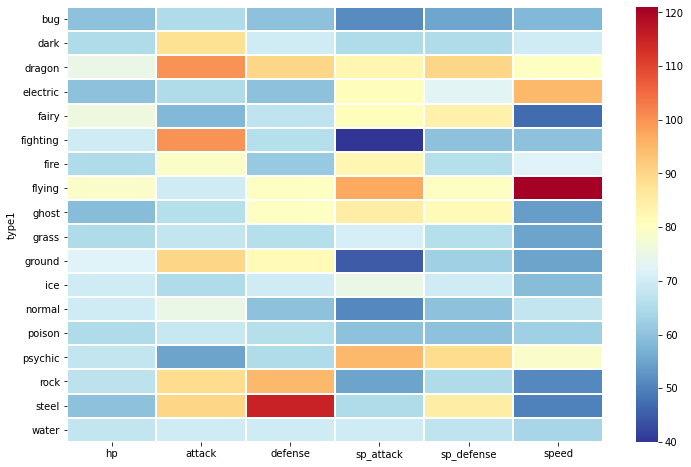

In [30]:
cols = ['hp','attack','defense','sp_attack', 'sp_defense', 'speed']
plt.figure(figsize=(12,8))
sns.heatmap(pokemon.groupby('type1')[cols].median(),
            linewidth=1, cmap='RdYlBu_r')

1. Fastest Pokemon is the flying type, electric type and dragon type
2. Dragonm, pyschic, and steel excel in special defense
3. Flying, pyshchic and ghost excel in special attack
4. Steel, rock and dragon type excel in defense
5. fighting and dragon type excel in attac
6. flying type Pokemon have the highest hit points among the Pokemon type1s

On a bird's veiw, flying type appears to be the most versatile Pokemon with high score on all the 6 attributes, followed by dragon(which also can fly

#### Legendary type1 Pokemons against their atttributes

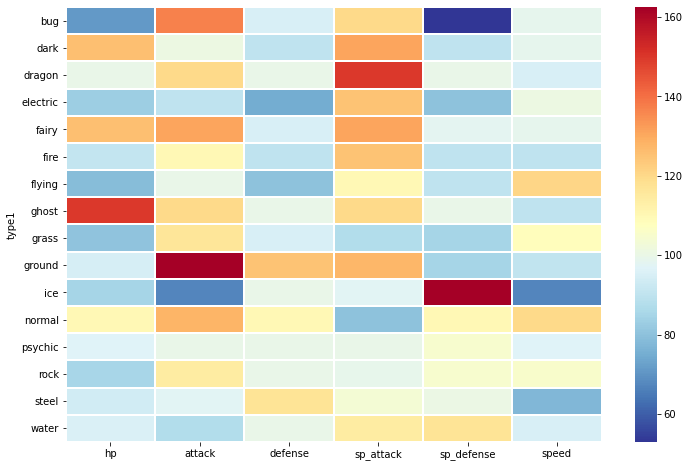

In [31]:
cols = ['hp','attack','defense','sp_attack', 'sp_defense', 'speed']
plt.figure(figsize=(12,8))
sns.heatmap(pokemon[pokemon['is_legendary']==1].groupby('type1')[cols].median(),
            linewidth=1, cmap='RdYlBu_r')

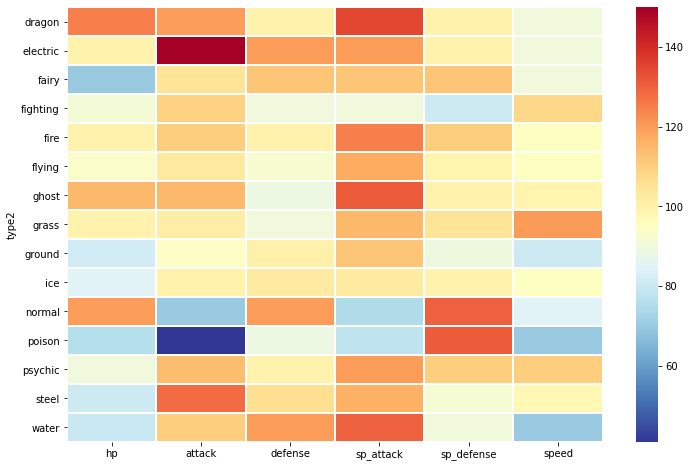

In [32]:
cols = ['hp','attack','defense','sp_attack', 'sp_defense', 'speed']
plt.figure(figsize=(12,8))
sns.heatmap(pokemon[pokemon['is_legendary']==1].groupby('type2')[cols].median(),
            linewidth=1, cmap='RdYlBu_r')

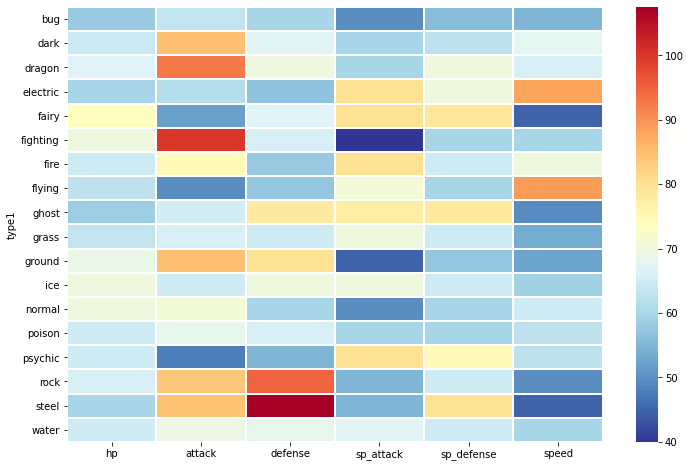

In [33]:
cols = ['hp','attack','defense','sp_attack', 'sp_defense', 'speed']
plt.figure(figsize=(12,8))
sns.heatmap(pokemon[pokemon['is_legendary']==0].groupby('type1')[cols].median(),
            linewidth=1, cmap='RdYlBu_r')

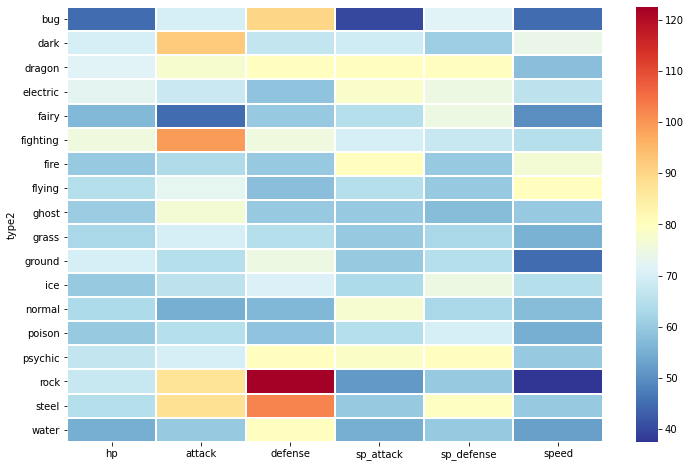

In [34]:
cols = ['hp','attack','defense','sp_attack', 'sp_defense', 'speed']
plt.figure(figsize=(12,8))
sns.heatmap(pokemon[pokemon['is_legendary']==0].groupby('type2')[cols].median(),
            linewidth=1, cmap='RdYlBu_r')

### Let us explore the dataset and see the variation over the Legendary kind

#### How many Legendary and non Legendary Pokemons are there?

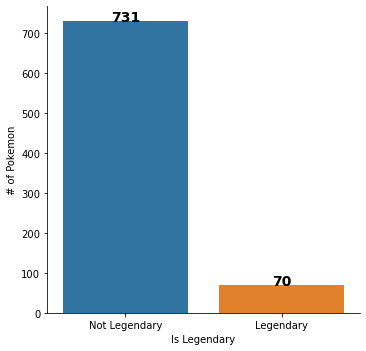

In [35]:
#pokemon['is_legendary'].value_counts().plot(kind='bar',x='is_legendary')
#plt.xticks((0,1), ('Not Legendary','Legendary'), rotation=0);

plot = sns.catplot(x='is_legendary', data=pokemon, kind='count', height=5, aspect=1).set_axis_labels('Is Legendary', '# of Pokemon')
# To plot the data labels
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+10, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=14)
plt.xticks((0,1), ('Not Legendary','Legendary'), rotation=0);

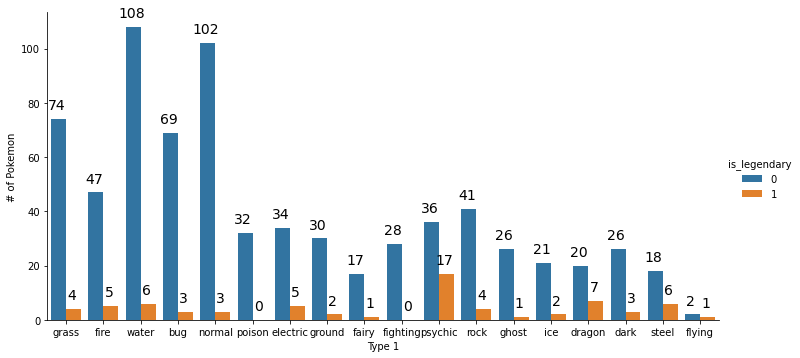

In [36]:
plot = sns.catplot(x='type1', data=pokemon, kind='count', hue='is_legendary',
                   height=5, aspect=2).set_axis_labels('Type 1', '# of Pokemon')

# To plot the data labels
for bar in plot.ax.patches:
    if(math.isnan(bar.get_height())):
        h=0
    else:
        h = bar.get_height()
    i = bar.get_xy()[0]
    plot.ax.text(
        i+0.15, # bar index (x coordinate of text)
        h+5, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        size=14)

Psychic type1 is the most occuring Legendary Pokemon

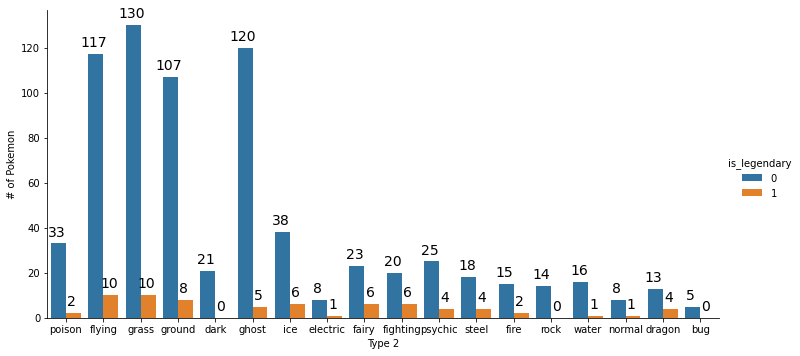

In [37]:
plot = sns.catplot(x='type2', data=pokemon, kind='count', hue='is_legendary',
                   height=5, aspect=2).set_axis_labels('Type 2', '# of Pokemon')

# To plot the data labels
for bar in plot.ax.patches:
    if(math.isnan(bar.get_height())):
        h=0
    else:
        h = bar.get_height()
    i = bar.get_xy()[0]
    plot.ax.text(
        i+0.15, # bar index (x coordinate of text)
        h+5, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        size=14)

Flying and grass type2 is the is the most occuring Legendary Pokemon

#### Vulnerability of Pokemon

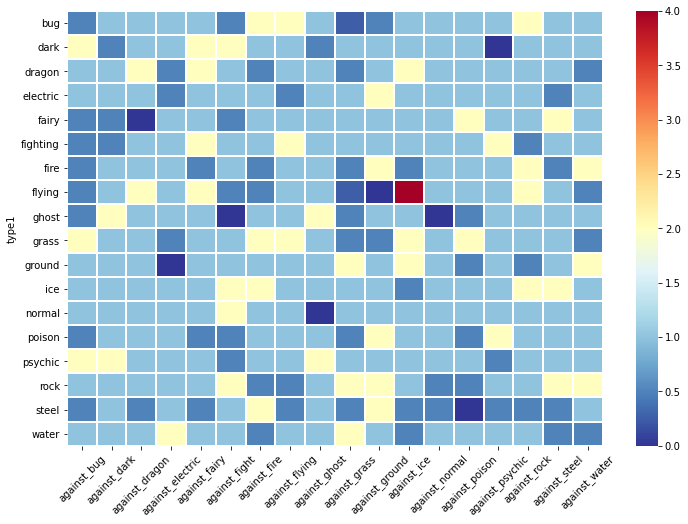

In [38]:
cols = ['against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight',
           'against_fire','against_flying', 'against_ghost', 'against_grass', 'against_ground', 'against_ice',
           'against_normal', 'against_poison', 'against_psychic', 'against_rock', 'against_steel', 'against_water']
plt.figure(figsize=(12,8))
sns.heatmap(pokemon.groupby('type1')[cols].median(),
            linewidth=1, cmap='RdYlBu_r')
plt.xticks(rotation=45);

The above chart shows the damage taken against an attack i.e., the vulnerability of a Pokemon of type1 against an attack.<br>
The Steel Pokemon is the least vulnerable against attacks

#### Distribution of Pokemon types across Legendary and Not Legendary Pokemon

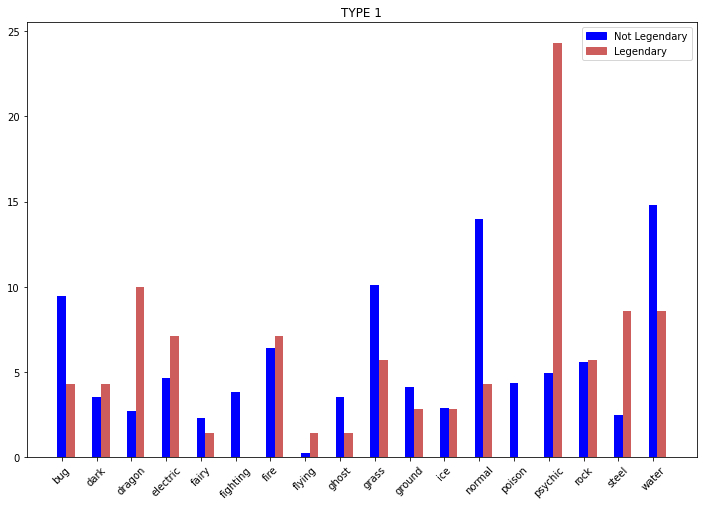

In [39]:
# Prepare the data
pokemon_dist_type1 = pd.pivot_table(data=pokemon, index='type1',columns='is_legendary',
                                    aggfunc='count', values='name').reset_index(level=0)
pokemon_dist_type1.columns = ['type1', 'Not Legendary', 'Legendary']
pokemon_dist_type1 = pokemon_dist_type1.fillna(0)
pokemon_dist_type1['Not Legendary'] = round(pokemon_dist_type1['Not Legendary']/sum(pokemon_dist_type1['Not Legendary'])*100,2)
pokemon_dist_type1['Legendary'] = round(pokemon_dist_type1['Legendary']/sum(pokemon_dist_type1['Legendary'])*100,2)

# Plot the data
fig, axes = plt.subplots(1,1, figsize=(12,8))
X = np.arange(0, len(pokemon_dist_type1['type1']))
plt.bar(x=X+0.0, width=0.25, height=pokemon_dist_type1['Not Legendary'],color='b')
plt.bar(x=X+0.25, width=0.25, height=pokemon_dist_type1['Legendary'], color='indianred');
plt.xticks(X, pokemon_dist_type1['type1'], rotation=45);

red_patch = mpatches.Patch(color='b', label='Not Legendary')
blue_patch = mpatches.Patch(color='indianred', label='Legendary')
plt.legend(handles=[red_patch, blue_patch])
plt.title('TYPE 1');

Legendary Pokemon are more likely to have Dragon, electric, psychic and steel type attributes. <br>
Type1 attribute shows a a signficant variability between Legendary and Non Legendary Pokemon and is an important attribute that can be used for classification

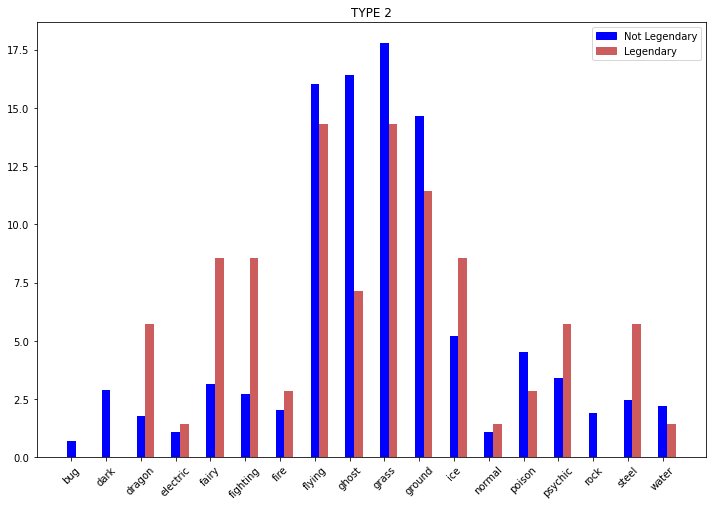

In [40]:
pokemon_dist_type2 = pd.pivot_table(data=pokemon, index='type2',columns='is_legendary',
                                    aggfunc='count', values='name').reset_index(level=0)
pokemon_dist_type2.columns = ['type2', 'Not Legendary', 'Legendary']
pokemon_dist_type2 = pokemon_dist_type2.fillna(0)
pokemon_dist_type2['Not Legendary'] = round(pokemon_dist_type2['Not Legendary']/sum(pokemon_dist_type2['Not Legendary'])*100,2)
pokemon_dist_type2['Legendary'] = round(pokemon_dist_type2['Legendary']/sum(pokemon_dist_type2['Legendary'])*100,2)
pokemon_dist_type2


fig, axes = plt.subplots(1,1, figsize=(12,8))
X = np.arange(0, len(pokemon_dist_type2['type2']))
plt.bar(x=X+0.0, width=0.25, height=pokemon_dist_type2['Not Legendary'],color='b')
plt.bar(x=X+0.25, width=0.25, height=pokemon_dist_type2['Legendary'], color='indianred');
plt.xticks(X, pokemon_dist_type2['type2'], rotation=45);

red_patch = mpatches.Patch(color='b', label='Not Legendary')
blue_patch = mpatches.Patch(color='indianred', label='Legendary')
plt.legend(handles=[red_patch, blue_patch])
plt.title('TYPE 2');

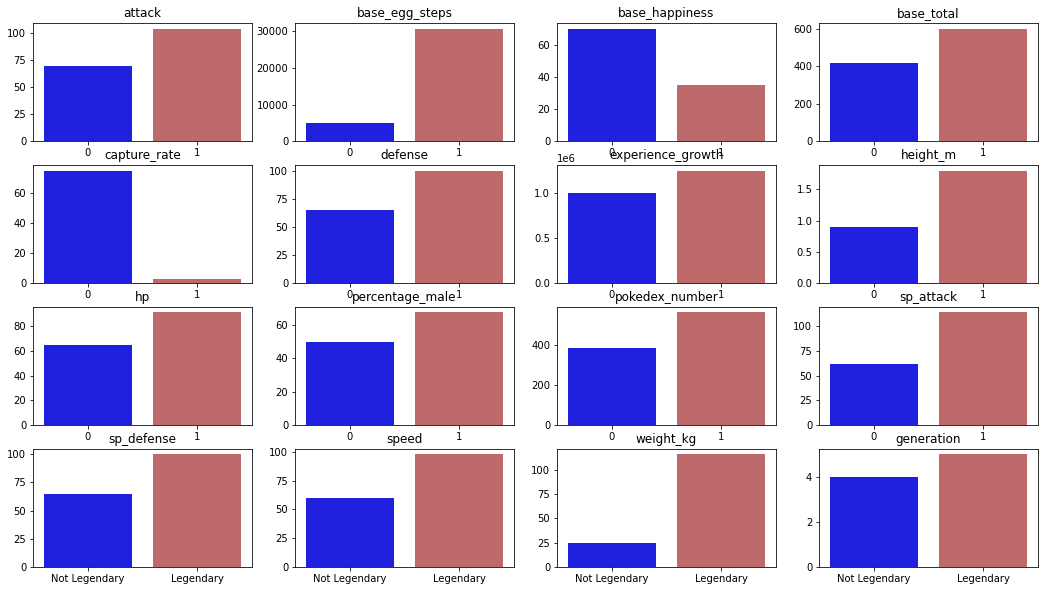

In [41]:
# Generate the attribute list
attribute_list = ['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense',
                  'experience_growth', 'height_m', 'hp', 'percentage_male', 'pokedex_number', 'sp_attack',
                  'sp_defense', 'speed','weight_kg', 'generation']

k = 0
fig,(ax) = plt.subplots(ncols=4,nrows=4, figsize=(18,10))

for i in range (0,4):
    for j in range(0,4):
        df = pd.DataFrame(pokemon.groupby('is_legendary')[attribute_list[k]].median().reset_index(drop=True, name=attribute_list[k]))
        sns.barplot(x=df.index, y=attribute_list[k], data=df, ax=ax[i][j], ci=None, palette=['b', 'indianred'])
        ax[i][j].set_ylabel(None)
        ax[i][j].set_title(attribute_list[k])
        if (i == 3):
            ax[i][j].set_xticks((0,1))
            ax[i][j].set_xticklabels(['Not Legendary','Legendary'])
        k += 1

Except for the "hp" and base happiness atttribute all other attributes are higher for Legendary Pokemon

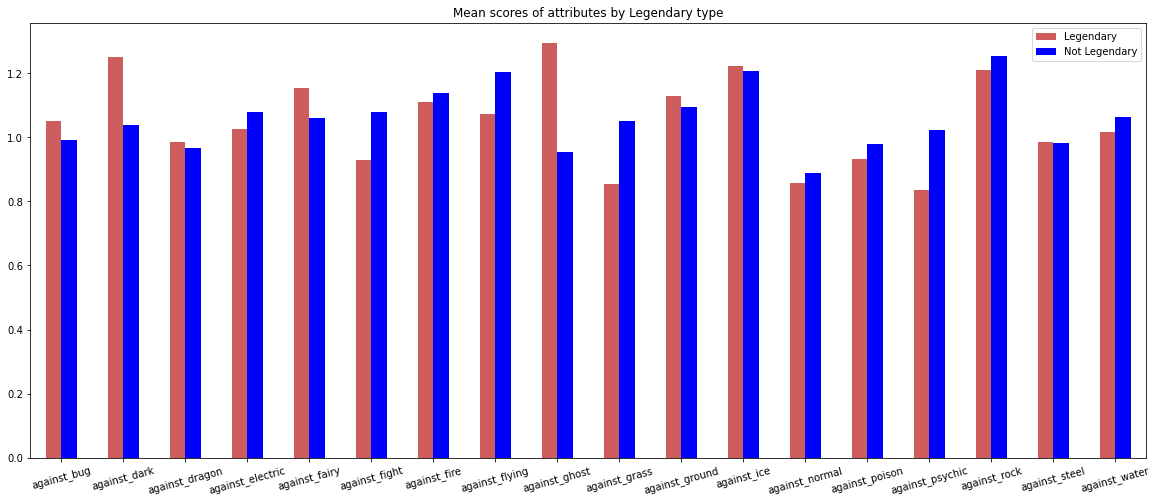

In [42]:
columns = ['against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight',
           'against_fire','against_flying', 'against_ghost', 'against_grass', 'against_ground', 'against_ice',
           'against_normal', 'against_poison', 'against_psychic', 'against_rock', 'against_steel', 'against_water']
draw_barplot(pokemon, columns, 'is_legendary')

#### Conclusion from exploratory data analysis

1. Dataset provided is imbalanced in terms of the classification of Legendary vs Non Legendary Pokemons
2. Dataset provided describes the strenghts and vulnerability aspects of the Pokemon species
3. In terms of the top 10 strongest Pokemon, 8 Legendary Pokemons occupy the top slots
4. But in terms of least vulnerable Pokemons, only 3 Legendary Pokemons are present in the top 10
5. In terms of strength Dragon type Pokemon stands out
6. And in terms of resilence Steel type Pokemon stands out
7. Both of these are the attributes commonly found in Legendary Pokemon
9. Psychic type1 is the most occuring Legendary Pokemon
10. Flying and grass type2 is the is the most occuring Legendary Pokemon
11. On the strength side: 
    1. Dragonm, pyschic, and steel excel in special defense
    2. Flying, pyshchic and ghost excel in special attack
    3. Steel, rock and dragon type excel in defense
12. On the Vulnerability side:
    1. The Steel Pokemon is the least vulnerable against attacks
    2. Flying type is highly vulnerable against attacks from ground type Pokemon
13. Base happiness is lower for Legendary Pokemons
14. Dark and ghost are the weak points of Legendary Pokemons as they sustain the most damage from their attacks

## 5. Running the Prediction Algorithms <a class="anchor" id="section5"></a>

##### Preparing the dataset for the algorithm

In [43]:
cols = ['against_bug', 'against_dark', 'against_dragon','against_electric', 'against_fairy', 'against_fight',
        'against_fire','against_flying', 'against_ghost', 'against_grass', 'against_ground','against_ice',
        'against_normal', 'against_poison', 'against_psychic','against_rock', 'against_steel', 'against_water',
        'attack','base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense',
        'experience_growth', 'height_m', 'hp','percentage_male','sp_attack', 'sp_defense', 'speed',
        'type1', 'type2', 'weight_kg', 'generation', 'is_legendary']

In [217]:
data = pokemon[cols]
data

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,hp,percentage_male,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,45,88.100000,65,65,45,grass,poison,6.9,1,0
1,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,60,88.100000,80,80,60,grass,poison,13.0,1,0
2,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,80,88.100000,122,120,80,grass,poison,100.0,1,0
3,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,39,88.100000,60,50,65,fire,flying,8.5,1,0
4,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,58,88.100000,80,65,80,fire,flying,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,0.25,...,97,69.702718,107,101,61,steel,flying,999.9,7,1
797,1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,0.25,...,59,54.309946,59,31,109,grass,steel,0.1,7,1
798,2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,0.50,...,223,55.721112,97,53,43,dark,dragon,888.0,7,1
799,2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.00,...,97,73.213061,127,89,79,psychic,ground,230.0,7,1


#### Balance the dataset

In [218]:
legendaryPokemon = data[data['is_legendary']==1]
normalPokemon = data[data['is_legendary']==0]
sampledNormalPokemon = normalPokemon.sample(100)
sampledNormalPokemon

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,hp,percentage_male,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
283,0.50,1.0,1.0,2.0,1.00,0.25,2.00,2.0,1.0,0.25,...,70,50.0,100,82,80,bug,flying,3.6,3,0
229,1.00,1.0,2.0,1.0,2.00,1.00,0.25,1.0,1.0,1.00,...,75,50.0,95,95,85,water,dragon,152.0,2,0
308,1.00,1.0,1.0,0.5,1.00,1.00,1.00,0.5,1.0,1.00,...,40,50.0,65,40,65,electric,ice,15.2,3,0
781,1.00,1.0,2.0,0.5,2.00,1.00,0.50,1.0,1.0,0.50,...,45,50.0,45,45,45,dragon,ghost,29.7,7,0
604,2.00,2.0,1.0,1.0,1.00,0.50,1.00,1.0,2.0,1.00,...,55,50.0,85,55,30,psychic,ground,9.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.00,1.0,1.0,2.0,1.00,1.00,0.50,1.0,1.0,2.00,...,40,50.0,40,40,90,water,ghost,12.4,1,0
692,1.00,1.0,1.0,2.0,1.00,1.00,0.50,1.0,1.0,2.00,...,71,50.0,120,89,59,water,grass,35.3,6,0
170,1.00,1.0,1.0,1.0,1.00,1.00,0.50,0.5,1.0,2.00,...,125,50.0,76,76,67,water,electric,22.5,2,0
757,0.25,1.0,1.0,1.0,0.25,0.50,0.50,1.0,1.0,0.25,...,68,0.0,111,60,117,poison,fire,22.2,7,0


In [219]:
x = pd.concat([legendaryPokemon, sampledNormalPokemon])
x = pd.get_dummies(x)
y = x['is_legendary']
x = x.drop('is_legendary',1)
x

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,type2_flying,type2_ghost,type2_grass,type2_ground,type2_ice,type2_normal,type2_poison,type2_psychic,type2_steel,type2_water
143,0.50,1.0,1.0,2.0,1.00,1.00,2.0,1.0,1.0,0.50,...,1,0,0,0,0,0,0,0,0,0
144,0.50,1.0,1.0,1.0,1.00,0.50,1.0,0.5,1.0,0.50,...,1,0,0,0,0,0,0,0,0,0
145,0.25,1.0,1.0,2.0,0.50,0.50,0.5,1.0,1.0,0.25,...,1,0,0,0,0,0,0,0,0,0
149,2.00,2.0,1.0,1.0,1.00,0.50,1.0,1.0,2.0,1.00,...,0,0,1,0,0,0,0,0,0,0
150,2.00,2.0,1.0,1.0,1.00,0.50,1.0,1.0,2.0,1.00,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.00,1.0,1.0,2.0,1.00,1.00,0.5,1.0,1.0,2.00,...,0,1,0,0,0,0,0,0,0,0
692,1.00,1.0,1.0,2.0,1.00,1.00,0.5,1.0,1.0,2.00,...,0,0,1,0,0,0,0,0,0,0
170,1.00,1.0,1.0,1.0,1.00,1.00,0.5,0.5,1.0,2.00,...,0,0,0,0,0,0,0,0,0,0
757,0.25,1.0,1.0,1.0,0.25,0.50,0.5,1.0,1.0,0.25,...,0,0,0,0,0,0,0,0,0,0


In [47]:
y

143    1
144    1
145    1
149    1
150    1
      ..
148    0
608    0
447    0
577    0
27     0
Name: is_legendary, Length: 170, dtype: int64

#### Train test split

In [220]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.25)

#### The Balancing Act

In [221]:
sm = SMOTE(sampling_strategy=1.0, random_state=0, k_neighbors=5)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#X_train_res, y_train_res = X_train, y_train

In [222]:
print(X_train_res.shape)
print((y_train_res==1).sum())
print((y_train_res==0).sum())

(154, 67)
77
77


#### Using Random Forest Classifier

In [223]:
model = RandomForestClassifier(n_estimators=50,max_depth=3)
model.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=3, n_estimators=50)

#### Print the results

In [224]:
y_pred =  model.predict(X_test)
print('Accuracy Score on train data: ', accuracy_score(y_true=y_train_res, y_pred=model.predict(X_train_res)))
print('Accuracy Score on test data: ', accuracy_score(y_true=y_test, y_pred=y_pred))

Accuracy Score on train data:  1.0
Accuracy Score on test data:  0.9767441860465116


#### Check for feature importance

In [225]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(10)

,importance
feature,
base_total,0.210
base_egg_steps,0.192
percentage_male,0.106
experience_growth,0.078
base_happiness,0.056
capture_rate,0.047
defense,0.045
height_m,0.032
sp_defense,0.028


In [226]:
results = pd.DataFrame(columns=['Algorithm','MAE', 'MSE', 'RMSE', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

#### Decision Tree classifier

In [227]:
dtree = DecisionTreeClassifier(max_depth=5)
y_pred_train, y_pred_test = train_predict(X_train_res, y_train_res, X_test, dtree)
results_dtree = model_evaluation(y_test, y_pred_test, 'DTree Test')
results = results.append(results_dtree, ignore_index=True)
results_dtree = model_evaluation(y_train_res, y_pred_train, 'DTree Train')
results = results.append(results_dtree, ignore_index=True)


  DTree Test
CONFUSION MATRIX
    0   1
0  21   2
1   2  18
Mean Absolute Error: 0.09
Mean Squaared Error: 0.09
Root Mean Squaared Error: 0.3
Accuracy: 0.91
Precision : 0.91
Recall : 0.91
F1_score : 0.91

  DTree Train
CONFUSION MATRIX
    0   1
0  77   0
1   0  77
Mean Absolute Error: 0.0
Mean Squaared Error: 0.0
Root Mean Squaared Error: 0.0
Accuracy: 1.0
Precision : 1.0
Recall : 1.0
F1_score : 1.0


#### Random Forest Classifier

In [228]:
rfc = RandomForestClassifier()
y_pred_train, y_pred_test = train_predict(X_train_res, y_train_res, X_test, rfc)
results_rfc = model_evaluation(y_test, y_pred_test, 'RFC Test')
results = results.append(results_rfc, ignore_index=True)
results_rfc = model_evaluation(y_train_res, y_pred_train, 'RFC Train')
results = results.append(results_rfc, ignore_index=True)


  RFC Test
CONFUSION MATRIX
    0   1
0  23   0
1   0  20
Mean Absolute Error: 0.0
Mean Squaared Error: 0.0
Root Mean Squaared Error: 0.0
Accuracy: 1.0
Precision : 1.0
Recall : 1.0
F1_score : 1.0

  RFC Train
CONFUSION MATRIX
    0   1
0  77   0
1   0  77
Mean Absolute Error: 0.0
Mean Squaared Error: 0.0
Root Mean Squaared Error: 0.0
Accuracy: 1.0
Precision : 1.0
Recall : 1.0
F1_score : 1.0


In [229]:
knn = KNeighborsClassifier(n_neighbors=10)
y_pred_train, y_pred_test = train_predict(X_train_res, y_train_res, X_test, knn)
results_knn = model_evaluation(y_test, y_pred_test, 'K-NN Test')
results = results.append(results_knn, ignore_index=True)
results_knn = model_evaluation(y_train_res, y_pred_train, 'K-NN Train')
results = results.append(results_knn, ignore_index=True)


  K-NN Test
CONFUSION MATRIX
    0   1
0  23   0
1   6  14
Mean Absolute Error: 0.14
Mean Squaared Error: 0.14
Root Mean Squaared Error: 0.37
Accuracy: 0.86
Precision : 0.9
Recall : 0.85
F1_score : 0.85

  K-NN Train
CONFUSION MATRIX
    0   1
0  77   0
1   5  72
Mean Absolute Error: 0.03
Mean Squaared Error: 0.03
Root Mean Squaared Error: 0.17
Accuracy: 0.97
Precision : 0.97
Recall : 0.97
F1_score : 0.97


#### Correcting the overfitting using GridsearchCV

In [230]:
tree_param = [{'criterion':['gini', 'entropy'],
               'max_features':['sqrt','log2', None],
               'max_depth': np.arange(1,30,2),
               'min_samples_split': [10]
               }]

#### Desicision Tree classifier with GSCV

In [231]:
dtree_gscv = DecisionTreeClassifier()
grid_search = GridSearchCV(dtree_gscv, tree_param, cv=10)

y_gscv_pred_train, y_gscv_pred_test = train_predict(X_train_res, y_train_res,
                                                            X_test, grid_search)
results_dtree_gscv_test = model_evaluation(y_test, y_gscv_pred_test, 'DTree GSCV Test')
results_dtree_gscv_train = model_evaluation(y_train_res, y_gscv_pred_train, 'DTree GSCV PCA Train')
results = results.append(results_dtree_gscv_test, ignore_index=True)
results = results.append(results_dtree_gscv_train, ignore_index=True)


  DTree GSCV Test
CONFUSION MATRIX
    0   1
0  23   0
1   0  20
Mean Absolute Error: 0.0
Mean Squaared Error: 0.0
Root Mean Squaared Error: 0.0
Accuracy: 1.0
Precision : 1.0
Recall : 1.0
F1_score : 1.0

  DTree GSCV PCA Train
CONFUSION MATRIX
    0   1
0  77   0
1   0  77
Mean Absolute Error: 0.0
Mean Squaared Error: 0.0
Root Mean Squaared Error: 0.0
Accuracy: 1.0
Precision : 1.0
Recall : 1.0
F1_score : 1.0


#### Random Forest classifier with GSCV

In [233]:
rfc_param = [{'n_estimators':range(10,15),
              'criterion':['gini', 'entropy'],
              'max_depth': np.arange(1,30,2),
              'min_samples_split': [10],
              'max_features': ['sqrt','log2', None]}]

In [234]:
rfc_gscv = RandomForestClassifier()
grid_search = GridSearchCV(rfc_gscv, rfc_param, cv=10)

y_gscv_pred_train, y_gscv_pred_test = train_predict(X_train_res, y_train_res,
                                                    X_test, grid_search)
results_rfc_gscv_test = model_evaluation(y_test, y_gscv_pred_test, 'RFC GSCV Test')
results_rfc_gscv_train = model_evaluation(y_train_res, y_gscv_pred_train, 'RFC GSCV Train')
results = results.append(results_rfc_gscv_test, ignore_index=True)
results = results.append(results_rfc_gscv_train, ignore_index=True)


  RFC GSCV Test
CONFUSION MATRIX
    0   1
0  23   0
1   0  20
Mean Absolute Error: 0.0
Mean Squaared Error: 0.0
Root Mean Squaared Error: 0.0
Accuracy: 1.0
Precision : 1.0
Recall : 1.0
F1_score : 1.0

  RFC GSCV Train
CONFUSION MATRIX
    0   1
0  75   2
1   1  76
Mean Absolute Error: 0.02
Mean Squaared Error: 0.02
Root Mean Squaared Error: 0.14
Accuracy: 0.98
Precision : 0.98
Recall : 0.98
F1_score : 0.98


#### K NN 

In [235]:
knn_param = [{'n_neighbors':np.arange(1,15,1)}]

In [236]:
knn_gscv = KNeighborsClassifier()
grid_search = GridSearchCV(knn_gscv, knn_param, cv=10)

y_gscv_pred_train, y_gscv_pred_test = train_predict(X_train_res, y_train_res,
                                                    X_test, grid_search)
results_knn_gscv_test = model_evaluation(y_test, y_gscv_pred_test, 'KNN GSCV Test')
results_knn_gscv_train = model_evaluation(y_train_res, y_gscv_pred_train, 'KNN GSCV Train')
results = results.append(results_knn_gscv_test, ignore_index=True)
results = results.append(results_knn_gscv_train, ignore_index=True)


  KNN GSCV Test
CONFUSION MATRIX
    0   1
0  23   0
1   5  15
Mean Absolute Error: 0.12
Mean Squaared Error: 0.12
Root Mean Squaared Error: 0.35
Accuracy: 0.88
Precision : 0.91
Recall : 0.88
F1_score : 0.87

  KNN GSCV Train
CONFUSION MATRIX
    0   1
0  77   0
1   2  75
Mean Absolute Error: 0.01
Mean Squaared Error: 0.01
Root Mean Squaared Error: 0.1
Accuracy: 0.99
Precision : 0.99
Recall : 0.99
F1_score : 0.99


#### Adaboost classifier for Decision Tree

The optimal number of max depth is 5


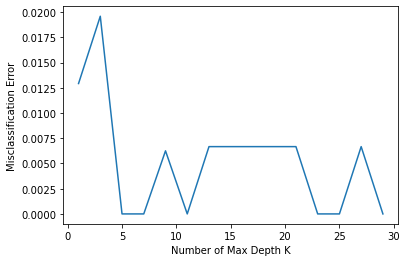

In [237]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList = np.arange(1,30,2)


# empty list that will hold cross validation scores
cv_scores = []

# perform 10-fold cross validation we are already familiar with
#n estimators：
for k in myList:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=k)
    scores = cross_val_score(clf, X_train_res, y_train_res, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[MSE.index(min(MSE))]
print("The optimal number of max depth is %d" % optimal_k)
# plot misclassification error vs k
plt.plot(myList, MSE)
plt.xlabel('Number of Max Depth K')
plt.ylabel('Misclassification Error')
plt.show()

## 6. Results <a class="anchor" id="section6"></a>

In [238]:
results

,Algorithm,MAE,MSE,RMSE,Accuracy,Precision,Recall,F1_Score
0,DTree Test,0.09,0.09,0.30,0.91,0.91,0.91,0.91
1,DTree Train,0.00,0.00,0.00,1.00,1.00,1.00,1.00
2,RFC Test,0.00,0.00,0.00,1.00,1.00,1.00,1.00
3,RFC Train,0.00,0.00,0.00,1.00,1.00,1.00,1.00
4,K-NN Test,0.14,0.14,0.37,0.86,0.90,0.85,0.85
5,K-NN Train,0.03,0.03,0.17,0.97,0.97,0.97,0.97
6,DTree GSCV Test,0.00,0.00,0.00,1.00,1.00,1.00,1.00
7,DTree GSCV PCA Train,0.00,0.00,0.00,1.00,1.00,1.00,1.00
8,RFC GSCV Test,0.00,0.00,0.00,1.00,1.00,1.00,1.00
9,RFC GSCV Train,0.02,0.02,0.14,0.98,0.98,0.98,0.98


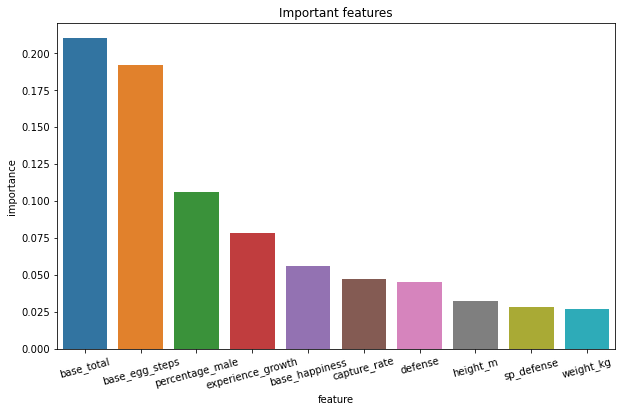

In [239]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = importances.reset_index(level=0)
plt.figure(figsize=(10,6))
sns.barplot(x='feature',y='importance', data=importances.head(10))
plt.xticks(rotation=15)
plt.title('Important features');

1. In this project, we implemented 3 different algorithms to classify Legendary Pokemon
2. We used SMOTE for sampling as Legendary Pokemons was a small population in the dataset
3. Among all models, K-NN Neigbors gave the best performance and Random Forest well cannot say worst performance but the results were questionable as it gave 100% accuracy for train and set
4. Gridsearchcv was used for tuning the model but there is still scope for better tuning the model to arrive at better outcome.
5. So used Adaboost to arrive at the optimal depth of the tree for decision tree algorithm.(tried to get optimal neighbors using cross-val-score but it gave output of 1, so dropped it)
6. From the Random Forest model extracted the top 10 import features. Considering that the output of the random forest is not feasible, we can at best say that the attributes we identified as important in our exploratory data analysis(attack, sp_defense) is confirmed by the feature importance output